In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM


In [6]:
model_path = {'mistral7b': 'mistralai/Mistral-7B-Instruct-v0.1',
             'falcon7b': 'tiiuae/falcon-7b-instruct',
              'llama7b': '/work/frink/models/Llama-2-7b-chat-hf',
             'flanul2': 'google/flan-ul2'}

def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_path[model_name],
                                         cache_dir = '/scratch/ramprasad.sa/huggingface_models')
    return tokenizer

def refine_df(df_path):
    df = pd.read_csv(df_path)
    #### since teacher forcing, make sure to only use rows where predicted is same as prev generated
    df['target_token_id'] = [eval(row['target_token'].split('_')[-1]) for idx, row in df.iterrows()]
    df = df[df['target_token_id'] == df['layer_token32']]
    return df

def read_model_probabilities_df(model_name, origin):
    data_path = f'/scratch/ramprasad.sa/probing_summarization_factuality/metric_scores/layer_wise_uncertainty_{model_name}_{origin}_document_context.csv'
    df_model = refine_df(data_path)
    tokenizer = load_tokenizer(model_name)
    return tokenizer, df_model

In [9]:
mistral_tokenizer, df_mistral = read_model_probabilities_df('mistral7b', 'xsum')
falcon_tokenizer, df_falcon = read_model_probabilities_df('falcon7b', 'xsum')
llama_tokenizer, df_llama = read_model_probabilities_df('llama7b', 'xsum')

In [11]:
len(df_mistral), len(df_falcon), len(df_llama)

(7508, 2197, 6370)

In [19]:
df_mistral.head()[:1]

,Unnamed: 0,target_token,label,layer_prob0,layer_token0,layer_target_token_prob0,layer_top3_predicted_probs0,layer_top3_predicted_tokens_key0,layer_prob1,layer_token1,...,layer_target_token_prob31,layer_top3_predicted_probs31,layer_top3_predicted_tokens_key31,layer_prob32,layer_token32,layer_target_token_prob32,layer_top3_predicted_probs32,layer_top3_predicted_tokens_key32,docid,target_token_id
0,0,009ebd25-1998-461f-adb6-4bc0c8556552_10823,0,0.000031,17190,0.000031,"[3.1321615097112954e-05, 3.13180462399032e-05,...","[17190, 18592, 16075]",0.000031,21309,...,0.00017,"[0.00017794671293813735, 0.0001700913853710517...","[6735, 10823, 13]",0.296866,10823,0.296866,"[0.2968662679195404, 0.1760723739862442, 0.159...","[10823, 6735, 10598]",1701434231:mistral7b-ul2,10823


In [16]:


#### RQ1 : For all "predicted" tokens where do they tend to surface inn top 3 first 
#### confidence of bubbled up tokens 
#### Factual vs non factual tokens
# 'first_layer_surfaced': [],
#     'first_layer_surfaced_prob': [],
#     'first_layer_surfaced_rank': [],


def check_new_word(row, prev_row, tokenizer):
    target_token = eval(row['target_token'].split('_')[-1])
    target_token_str = tokenizer.decode(target_token)
    # print(type(prev_row))
    if isinstance(prev_row, pd.core.frame.DataFrame):
        prev_docid = prev_row['docid'].values[0]
        if prev_docid == row['docid']:
            prev_token = prev_row['target_token_id'].values[0]
            prefix_str = tokenizer.decode([prev_token, target_token])
            if len(prefix_str.split(' ')) != len(target_token_str.split(' ')):
                return True
    return True
    
def make_probability_df_analysis(df_mistral, tokenizer):

    df_rq1_analysis = {
        'target_token': [],
        'label': [],
        'last_layer_token_prob': []
    }


    row_id = 0
    for idx, row in df_mistral.iterrows():
        # print(idx)
        prev_row = df_mistral.iloc[[row_id - 1]] if row_id > 0 else None
        is_new_word = check_new_word(row, prev_row, tokenizer)

        row_id += 1
        label = row['label']
        last_layer_token = row['layer_token32']
        last_layer_prob = row['layer_prob32']

        first_layer_surfaced = 0
        first_layer_surfaced_prob = 0
        first_layer_surfaced_rank = 0

        if is_new_word:
            for layer_idx in range(0, 33):
                layer_prob_key = f'layer_top3_predicted_probs{layer_idx}'
                layer_token_key = f'layer_top3_predicted_tokens_key{layer_idx}'

                layer_predicted_probs = eval(row[layer_prob_key])
                layer_predicted_tokens = eval(row[layer_token_key])


                layer_surface = 1 if last_layer_token in layer_predicted_tokens else 0 
                layer_surface_prob = 0
                layer_surface_rank = -1

                if layer_surface:
                    found_idx = layer_predicted_tokens.index(last_layer_token)
                    layer_surface_prob = layer_predicted_probs[found_idx]
                    layer_surface_rank = found_idx
    
                if f'layer_{layer_idx}' not in df_rq1_analysis:
                    df_rq1_analysis[f'layer_{layer_idx}'] = []
                if f'layer_prob{layer_idx}' not in df_rq1_analysis:
                    df_rq1_analysis[f'layer_prob{layer_idx}'] = []
                if f'layer_rank{layer_idx}' not in df_rq1_analysis:
                    df_rq1_analysis[f'layer_rank{layer_idx}'] = []

                df_rq1_analysis[f'layer_{layer_idx}'].append(layer_surface)
                df_rq1_analysis[f'layer_prob{layer_idx}'].append(layer_surface_prob)
                df_rq1_analysis[f'layer_rank{layer_idx}'].append(layer_surface_rank)
                
            df_rq1_analysis['target_token'].append(last_layer_token)
            df_rq1_analysis['label'].append(label)
            df_rq1_analysis['last_layer_token_prob'].append(last_layer_prob)

    df_rq1_analysis = pd.DataFrame(df_rq1_analysis)
    return df_rq1_analysis
                    

    

In [20]:
df_mistral_analysis = make_probability_df_analysis(df_mistral, mistral_tokenizer)
df_falcon_analysis = make_probability_df_analysis(df_falcon, falcon_tokenizer)
df_llama_analysis = make_probability_df_analysis(df_llama, llama_tokenizer)
len(df_mistral_analysis), len(df_falcon_analysis), len(df_llama_analysis)

(7508, 2197, 6370)

In [18]:
len(df_mistral_analysis)

7508

In [45]:
# set(list(df_rq1_analysis['layer_rank29'].values))
# df_rq1_analysis[df_rq1_analysis['layer_rank30'] == 2]

,target_token,label,last_layer_token_prob,layer_0,layer_prob0,layer_rank0,layer_1,layer_prob1,layer_rank1,layer_2,...,layer_rank29,layer_30,layer_prob30,layer_rank30,layer_31,layer_prob31,layer_rank31,layer_32,layer_prob32,layer_rank32
20,455,0,0.999887,0,0.0,-1,0,0.0,-1,0,...,-1,1,0.000120,2,1,0.000268,0,1,0.999887,0
49,28725,0,0.974571,0,0.0,-1,0,0.0,-1,0,...,1,1,0.000088,2,1,0.000167,0,1,0.974571,0
55,304,0,0.838372,0,0.0,-1,0,0.0,-1,0,...,2,1,0.000139,2,1,0.000214,0,1,0.838372,0
75,272,0,0.947063,0,0.0,-1,0,0.0,-1,0,...,-1,1,0.000166,2,1,0.000274,0,1,0.947063,0
98,28762,0,0.997199,0,0.0,-1,0,0.0,-1,0,...,-1,1,0.000121,2,1,0.000310,0,1,0.997199,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7417,272,0,0.754508,0,0.0,-1,0,0.0,-1,0,...,2,1,0.000136,2,1,0.000274,0,1,0.754508,0
7425,367,0,0.565997,0,0.0,-1,0,0.0,-1,0,...,2,1,0.000118,2,1,0.000220,0,1,0.565997,0
7433,10342,0,0.496655,0,0.0,-1,0,0.0,-1,0,...,0,1,0.000146,2,1,0.000199,0,1,0.496655,0
7449,28705,0,0.947743,0,0.0,-1,0,0.0,-1,0,...,-1,1,0.000149,2,1,0.000212,1,1,0.947743,0


In [43]:
##### early exit prediction same as last layer predictions 
##### at layer x how many tokens are already predicted 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def viz_lineplot(df):
    label_palettes = { 0: '#89B3CC', 1: '#BF4F51'}
    unique_models = set(df['model'].values)
    fig, axes = plt.subplots(1, len(unique_models), figsize=(15, 5))
    fig.suptitle('Factual vs nonfactual that have already been predicted via early exit(First token of a word)')
    for model_idx, model in enumerate(unique_models):
        df_model = df[df['model'] == model]
        sns.lineplot(x='layer', 
                    y='count', 
                    hue='label', 
                    data=df_model, 
                    ax=axes[model_idx], 
                    palette = label_palettes
                     
                )
        axes[model_idx].set_title(f'{model}')
        axes[model_idx].set_ylabel('% of times generated token has already been predicted')
        axes[model_idx].tick_params(axis='x', rotation=45)
        # plt.legend(['Factual', 'Non-factual']);
        # Show plot

    
    plt.savefig('early_exit_surfaced_lineplot.pdf')
    plt.tight_layout()
    plt.show()
    
    
def make_seaborn_plottable(df):
    df_collapse = {'label': [],
              'layer': [],
              'count': []}

    for label in [0, 1]:
        df_label = df[df['label'] == label]
        label_counts = df_label.sum()
        # print(label_counts)
        for k in label_counts.index:
            if 'layer' in k:
                df_collapse['layer'].append(k.split('_')[-1])
                df_collapse['count'].append(label_counts[k]/len(df_label))
                df_collapse['label'] += [label]
        
    df_collapse = pd.DataFrame(df_collapse)
    return df_collapse
    


def get_all_final_same_early_exit_predictions(df, 
                                             comparator,
                                             first_surfaced):
# df = df_rq1_analysis
    df_surfaced = {'label': []}
    for idx, row in df.iterrows():
        label = row['label']
        found = False
        for layer_idx in range(0, 33, 2):
            column_name_found = f'layer_{layer_idx}'
            column_name_rank = f'layer_rank{layer_idx}'
            if column_name_found not in df_surfaced:
                df_surfaced[column_name_found] = []
                
            val = 0
            if comparator == 'equal':
                if row[column_name_found] and row[column_name_rank] == 0:
                    if first_surfaced:
                        if not found:
                            val = 1
                            found = True
                        
                    else:
                        val = 1
            elif comparator == 'top3':
                if row[column_name_found]:
                    if first_surfaced:
                        if not found:
                            val = 1
                            found = True
                    else:
                        val = 1 
            df_surfaced[column_name_found].append(val)
        df_surfaced['label'] += [label]
        
    df_surfaced = pd.DataFrame(df_surfaced)    
    return df_surfaced
    


# df_surfaced = get_all_final_same_early_exit_predictions(df_rq1_analysis, comparator = 'equal', first_surfaced = True)  
# df_surfaced = make_seaborn_plottable(df_surfaced)
# viz_lineplot(df_surfaced)


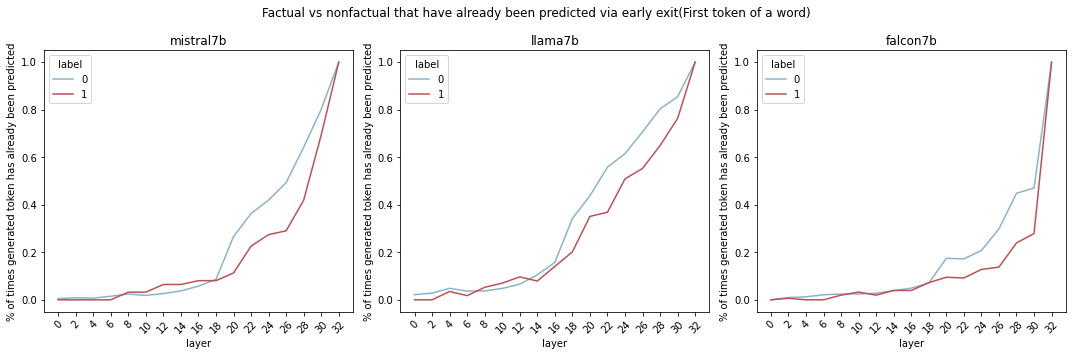

In [44]:
df_surfaced_mistral = get_all_final_same_early_exit_predictions(df_mistral_analysis, comparator = 'equal', first_surfaced = False)  
df_surfaced_mistral = make_seaborn_plottable(df_surfaced_mistral)
df_surfaced_falcon = get_all_final_same_early_exit_predictions(df_falcon_analysis, comparator = 'equal', first_surfaced = False)  
df_surfaced_falcon = make_seaborn_plottable(df_surfaced_falcon)
df_surfaced_llama = get_all_final_same_early_exit_predictions(df_llama_analysis, comparator = 'equal', first_surfaced = False)  
df_surfaced_llama = make_seaborn_plottable(df_surfaced_llama)
model_values = ['mistral7b'] * len(df_surfaced_mistral)  + ['falcon7b'] * len(df_surfaced_falcon)  + ['llama7b'] * len(df_surfaced_llama) 
# viz_lineplot(df_surfaced_mistral)

df_surfaced_all = pd.concat([df_surfaced_mistral, df_surfaced_falcon, df_surfaced_llama])
df_surfaced_all['model'] = model_values
viz_lineplot(df_surfaced_all)
# df_surfaced_all

In [136]:
df_first_surfaced_equal = get_all_final_same_early_exit_predictions(df_rq1_analysis, comparator = 'equal', first_surfaced = True)  
df_first_surfaced_equal = make_seaborn_plottable(df_first_surfaced_equal)

df_first_surfaced_top3 = get_all_final_same_early_exit_predictions(df_rq1_analysis, comparator = 'top3', first_surfaced = True)  
df_first_surfaced_top3 = make_seaborn_plottable(df_first_surfaced_top3)


In [46]:
def viz_barplot(df):
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    label_palettes = { 0: '#89B3CC', 1: '#BF4F51'}

    for label_idx, label in enumerate([0, 1]):
        
        # Plot for label 0
        sns.barplot(x='layer', 
                y='count', 
                hue='label', 
                data=df[df['label'] == label], 
                ax=axes[label_idx], 
                ci = None,
                palette = label_palettes
            )

        token_type = 'Factual' if label == 0 else 'Nonfactual'
        axes[label_idx].set_title(f'{token_type} Tokens (First token of a word)')
        axes[label_idx].set_ylabel('% of times generated token first surfaced in top3')
        axes[label_idx].tick_params(axis='x', rotation=45)
        axes[label_idx].legend().remove()

    # Show plot
    plt.savefig('first_time_surface_top3.pdf')
    plt.tight_layout()
    plt.show()

In [47]:
# viz_barplot(df_first_surfaced_equal)

In [51]:
# df_first_surfaced_top3_mistral = get_all_final_same_early_exit_predictions(df_mistral_analysis, comparator = 'top3', first_surfaced = True)  
# df_first_surfaced_top3_mistral = make_seaborn_plottable(df_first_surfaced_top3_mistral)

# viz_barplot(df_first_surfaced_top3_mistral)

In [52]:
# df_first_surfaced_top3_falcon = get_all_final_same_early_exit_predictions(df_falcon_analysis, comparator = 'top3', first_surfaced = True)  
# df_first_surfaced_top3_falcon = make_seaborn_plottable(df_first_surfaced_top3_falcon)

# viz_barplot(df_first_surfaced_top3_falcon)

In [53]:
# df_first_surfaced_top3_llama = get_all_final_same_early_exit_predictions(df_llama_analysis, comparator = 'top3', first_surfaced = True)  
# df_first_surfaced_top3_llama = make_seaborn_plottable(df_first_surfaced_top3_llama)

# viz_barplot(df_first_surfaced_top3_llama)

In [59]:
def viz_plot_flipped_predictions(df,
            x_axis_key,
            y_axis_key,
            hue_key):
    fig, axes = plt.subplots(1,1, figsize=(7, 5))

    label_palettes = { 0: '#89B3CC', 1: '#BF4F51'}

    sns.lineplot(x=x_axis_key, 
                y=y_axis_key, 
                hue=hue_key, 
                data=df, 
                ax=axes, 
                ci = None,
                palette=label_palettes)

    
    axes.set_title('Proportion of flipped predictions with respect to final prediction')
    axes.set_ylabel('flipped early exit predictions')
    axes.set_xlabel('layer')
    axes.tick_params(axis='x', rotation=45)
        # axes[label_idx].legend().remove()

    # Show plot
    legend_labels = ['Factual', 'Non-factual']
    plt.legend(labels=legend_labels)
    
    plt.tight_layout()
    plt.show()


def get_df_flipped(df):
    df_flipped_analysis = {'layer': [],
                          'early_exit_match': [],
                          'label'  : []
                          }

    for label in [0, 1]:
        df_label = df[df['label']== label]
        for layer_idx in range(0, 33,2):
            rank_key = f'layer_rank{layer_idx}'
            rank_vals = list(df_label[rank_key].values)
            surfaced_count = rank_vals.count(1)
            df_flipped_analysis['layer'] +=  [layer_idx] 
            df_flipped_analysis['early_exit_match'] +=  [(len(df_label) - surfaced_count)/len(df_label)] 
            df_flipped_analysis['label'] +=  [label] 
            
    
    df_flipped_analysis = pd.DataFrame(df_flipped_analysis)
    return df_flipped_analysis
    
# df_flipped_analysis = get_df_flipped(df_rq1_analysis)

/tmp/ipykernel_1596/4233741980.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_axis_key,


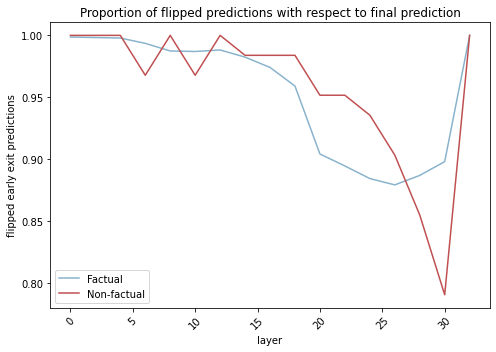

In [60]:
df_flipped_analysis_mistral = get_df_flipped(df_mistral_analysis)
viz_plot_flipped_predictions(df_flipped_analysis_mistral,
                             x_axis_key = 'layer', 
                             y_axis_key ='early_exit_match', 
                             hue_key = 'label')

/tmp/ipykernel_1596/4233741980.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_axis_key,


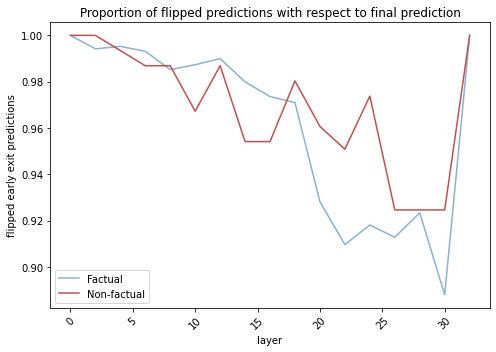

In [61]:
df_flipped_analysis_falcon = get_df_flipped(df_falcon_analysis)
viz_plot_flipped_predictions(df_flipped_analysis_falcon,
                             x_axis_key = 'layer', 
                             y_axis_key ='early_exit_match', 
                             hue_key = 'label')

/tmp/ipykernel_1596/4233741980.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=x_axis_key,


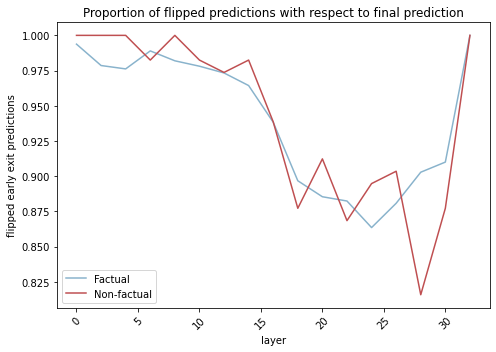

In [62]:
df_flipped_analysis_llama = get_df_flipped(df_llama_analysis)
viz_plot_flipped_predictions(df_flipped_analysis_llama,
                             x_axis_key = 'layer', 
                             y_axis_key ='early_exit_match', 
                             hue_key = 'label')

In [130]:
import numpy as np

percentiles = [i for i in range(0, 100, 20)]

result = np.percentile(list(df_rq1_analysis['layer_prob32'].values), percentiles)


In [131]:
result

array([0.20196278, 0.83659849, 0.98294121, 0.99862409, 0.99988222])

In [126]:
df_confidence_analysis = { 'percentile': [],
                          'label': [],
                          'proportion': [],
                         }


# % of factual tokens that are underconfident 
# % of nonfactual tokens that are overconfident 

factual_tokens = df_rq1_analysis[df_rq1_analysis['label'] == 0]
nonfactual_tokens = df_rq1_analysis[df_rq1_analysis['label'] == 1]

prev_cutoff = 0
for percentile, cutoff in list(zip(percentiles, result)):
    print(percentile, cutoff)
    perc_df = df_rq1_analysis[df_rq1_analysis['layer_prob32'] < cutoff]
    perc_df = perc_df[perc_df['layer_prob32'] > prev_cutoff]
    factual_perc =  list(perc_df['label'].values).count(0)
    nonfactual_perc =  list(perc_df['label'].values).count(1)
    
    df_confidence_analysis['percentile'].append(percentile)
    df_confidence_analysis['label'].append(0)
    df_confidence_analysis['proportion'].append(factual_perc/len(factual_tokens))

    
    df_confidence_analysis['percentile'].append(percentile)
    df_confidence_analysis['label'].append(1)
    df_confidence_analysis['proportion'].append(nonfactual_perc/len(nonfactual_tokens))
    prev_cutoff = cutoff
df_confidence_analysis = pd.DataFrame(df_confidence_analysis)
df_confidence_analysis


0 0.20196278393268585
10 0.6563554525375366
20 0.8365984916687011
30 0.9407884478569031
40 0.982941210269928
50 0.9956218600273132
60 0.9986240863800049
70 0.9996109724044799
80 0.9998822212219238
90 0.999977421760559


,percentile,label,proportion
0,0,0,0.000000
1,0,1,0.000000
2,10,0,0.098174
3,10,1,0.306452
4,20,0,0.100054
5,20,1,0.096774
6,30,0,0.099651
7,30,1,0.129032
8,40,0,0.099517
9,40,1,0.112903


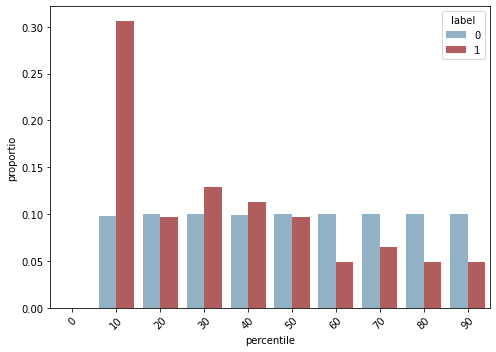

In [134]:
fig, axes = plt.subplots(1,1, figsize=(7, 5))

label_palettes = { 0: '#89B3CC', 1: '#BF4F51'}

sns.barplot(x='percentile', 
                y='proportion', 
                hue='label', 
                data=df_confidence_analysis, 
                palette=label_palettes
                )

    
# axes.set_title('Proportion of flipped predictions with respect to final prediction')
axes.set_ylabel('proportio')
axes.set_xlabel('percentile')
axes.tick_params(axis='x', rotation=45)
        # axes[label_idx].legend().remove()


    
plt.tight_layout()
plt.show()